# CAPSTONE PROJECT 2: A COMPUTER VISION MODEL WHICH DETECTS BONE FRACTURES IN THE UPPER EXTREMITIES NAMELY: WRISTS, FOREARMS, UPPER ARM, & SHOULDER FRACTURES
#### Modeling

***
Goal: Build two to three different models and identify the best one. <br>
- Fit your models with a training dataset<bf>
Hint: Try a number of different models: you will want to compare their outputs in the
model evaluation stage. For example, if you’re writing a classification model, you should
implement both an entropy model and a Gini impurity model. For hyperparameter tuning,
think of methods like cross-validation.<br>
- Review model outcomes — Iterate over additional models as needed<br>
Hint: you may want to use standard model evaluation metrics such as accuracy, recall,
precision, and F1.<br>
- Identify the final model that you think is the best model for this project<br>
Hint: the most powerful model isn’t always the best one to use. Other considerations
include computational complexity, scalability, and maintenance costs.<br>
Review the following questions and apply them to your analysis:<br>
- Does my data involve a time series or forecasting? If so, am I splitting the train
and test data appropriately?<br>
- Is my response variable continuous or categorical?<br>
***

### Training Models: <br>
We are going to train 3 models: The first being a basic Resnet model, which we will train without using and pretrained data on the model, and then we will do another Resnet Model using pretrained data.  Also as a fun exercise we will include a model which uses segmentation w/bounding boxes rather to see if we achieve a better performance, therefore we will be building a UNet() model as well.

In [1]:
import numpy as np
import pandas as pd
import os
import torch
from torch import nn
#import albumentations as A
import gc


import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
import torchvision
from torchvision.transforms import v2
import cv2
from torchvision.utils import draw_bounding_boxes
from PIL import Image

BS=12
LR=0.0001
epochs=5
IS=224
D='cuda' if torch.cuda.is_available() else 'cpu'

num_classes = 8
classes = {0:'elbow positive', 1:'fingers positive', 2:'forearm fracture', 
           3:'humerus fracture', 4:'humerus', 5:'shoulder fracture', 
           6:'wrist positive', 7:'no fracture'}

sub_paths = {
    'primaries': ['/train', '/valid', '/test'],
    'images': ['/train/images', '/valid/images', '/test/images',], 
    'labels': ['/train/labels', '/valid/labels', '/test/labels'],
            }

In [2]:
dir_path = '/kaggle/input/bone-fracture-detection-computer-vision-project'
train_path = dir_path + sub_paths['primaries'][0]
train_imgs = sorted(os.listdir(dir_path + sub_paths['images'][0]))
train_targets = sorted(os.listdir(dir_path + sub_paths['labels'][0]))

val_path = dir_path + sub_paths['primaries'][1]
val_imgs = sorted(os.listdir(dir_path + sub_paths['images'][1]))
val_targets = sorted(os.listdir(dir_path + sub_paths['labels'][1]))

test_path = dir_path + sub_paths['primaries'][2]
test_imgs = sorted(os.listdir(dir_path + sub_paths['images'][2]))
test_targets = sorted(os.listdir(dir_path + sub_paths['labels'][2]))


In [3]:
def import_boxes(list):
    '''
    Function for converting the text data in the labels files into functional
    dictionaries:  Given a list from a read file it converts that list and 
    returns a dictionary with correlated label and coordinate data.
    '''
    # Convert strings to ints and floats
    for i in range(0, len(list)):
        if len(list[i]) == 1:
            list[i] = int(float(list[i]))
        else:
            list[i] = float(list[i])
    # initialize variables        
    boxes = {'labels': [],
              'coords': []}
    i = -1
    neg_len = len(list) - (len(list) * 2)
    temp_list = []
    # Convert list to a functional dictionary of labels and coords
    while i >=  neg_len:
        if type(list[i]) == int:
            boxes['labels'].append(list[i])
            boxes['coords'].append(temp_list)
            temp_list = []
        else:
            temp_list.insert(0, list[i])
        i -= 1
    
    return boxes

In [4]:
train_targets[87]

'image1_1068_png.rf.16c11b00c6a28f6fca1a07da677b6e8e.txt'

In [5]:
idx_train = random.randint(0, len(train_imgs))
idx_val = random.randint(0, len(val_imgs))
idx_test = random.randint(0, len(test_imgs))

In [6]:
train_image_paths = os.path.join(train_path, 'images', train_imgs[idx_train])
train_target_paths = os.path.join(train_path, 'labels', train_targets[idx_train])

valid_image_paths = os.path.join(val_path, 'images', val_imgs[idx_val])
valid_target_paths = os.path.join(val_path, 'labels', val_targets[idx_val])

test_image_paths = os.path.join(val_path, 'images', test_imgs[idx_test])
test_target_paths = os.path.join(val_path, 'images', test_targets[idx_test])


In [7]:
# Set prepocess pipline
transform = v2.Compose([
   v2.Resize((IS, IS)),
   v2.ToImage(),
   v2.ToDtype(torch.float32, scale=True),
   v2.RandomAutocontrast(0.1),
   v2.RandomAdjustSharpness(0.1),
   v2.RandomErasing(0.1),
   v2.RandomHorizontalFlip(0.1),
   v2.RandomInvert(0.1)
   # transforms.FloatTensor(),
])

Data is now ready to be loaded into Dataset classes and DataLoaders for the models.

In [8]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None, mode='train'):
        self.transform = transform
        self.files = [f"{root}/{mode}/images/{name}" for name in os.listdir(root + f"/{mode}/images") if name.endswith(".jpg")]
        self.labels = {}
        self.boxes = {}
        assert len(self.files) > 0, "Make sure you downloaded the images!"

    def get_image(self, index):
        item = self.transform(Image.open(self.files[index]))
        if item.shape[0] != 3: 
            item = item.repeat(3, 1, 1)
        # Old versions of PyTorch didn't support normalization for different-channeled images
        return item
    
    def get_annot(self, index):
        labels = []
        boxes = []
        text_file = self.files[index].replace(".jpg", ".txt").replace("images", "labels")
        with open(text_file, mode="r") as f:
            lines = f.readlines()
            if len(lines) == 0:
                labels.append(7)
                boxes.append([1,1,2,2])
            else:
                for line in lines:
                    values = [value for value in line.split()]
                    bboxes = import_boxes(values)
                    # remove any odd boxes from poor labeling data.
                    for box in bboxes['coords']:
                        if len(box) % 4 != 0:
                            bboxes['coords'][0] = [val for i, val in enumerate(box) if val not in box[:i]]
                            if len(bboxes['coords'][0]) % 2 != 0:
                                bboxes['coords'][0].pop()
                     
                     # Convert bbox dimensions to fit the transformed image and load into annot variable
                for i in range(0, len(bboxes['labels'])):
                    coords = bboxes['coords'][i]
                    if len(coords) == 1 and len(coords) % 2 == 1 or len(coords) == 0:
                        labels.append(7)
                        boxes.append([1,1,2,2])
                    elif len(coords) % 2 == 1:
                        coords.pop()
                        coords = torch.reshape(torch.FloatTensor(coords), (int(len(coords)/2), 2))
                        size = torch.tensor([self.get_image(index).shape[2], self.get_image(index).shape[1]])
                        min_coords = torch.min(coords, dim=0).values * size
                        max_coords = torch.max(coords, dim=0).values * size
                        box = torch.cat((min_coords, max_coords), dim=0).tolist()
                        labels.append(bboxes['labels'][i])
                        boxes.append(box)
                    else:   
                        coords = torch.reshape(torch.FloatTensor(coords), (int(len(coords)/2), 2))
                        size = torch.tensor([self.get_image(index).shape[2], self.get_image(index).shape[1]])
                        min_coords = torch.min(coords, dim=0).values * size
                        max_coords = torch.max(coords, dim=0).values * size
                        box = torch.cat((min_coords, max_coords), dim=0).tolist()
                        labels.append(bboxes['labels'][i])
                        boxes.append(box)

        self.labels[index] = torch.Tensor(labels).long()
        self.boxes[index] = torch.Tensor(boxes).long()
                
        annot = {'labels': torch.Tensor(labels).long(), 'boxes': torch.Tensor(boxes).long()}  
        return annot

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, index):
        image = self.get_image(index)
        annot = self.get_annot(index)

        return image, annot

    def collate_fn(self, batch):
        return tuple(zip(*batch))

In [9]:
train_set = ImageDataset(dir_path, transform)
val_set = ImageDataset(dir_path, transform, mode='valid')
test_set = ImageDataset(dir_path, transform, mode='test')

train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size = BS,
                                           collate_fn = train_set.collate_fn,
                                           num_workers = 4)
val_loader = torch.utils.data.DataLoader(val_set,
                                        batch_size = BS,
                                        collate_fn = val_set.collate_fn)
test_loader = torch.utils.data.DataLoader(test_set,
                                         batch_size = BS,
                                         collate_fn = test_set.collate_fn)

In [10]:
print(f'Training Data:= {len(train_set)} images divided into {len(train_loader)} batches')
print(f'Validation Data:= {len(val_set)} images divided into {len(val_loader)} batches')
print(f'Testing Data:= {len(test_set)} images divided into {len(test_loader)} batches')

Training Data:= 3631 images divided into 303 batches
Validation Data:= 348 images divided into 29 batches
Testing Data:= 169 images divided into 15 batches


In [11]:
# Do a test iteration
image, target = next(iter(val_loader))

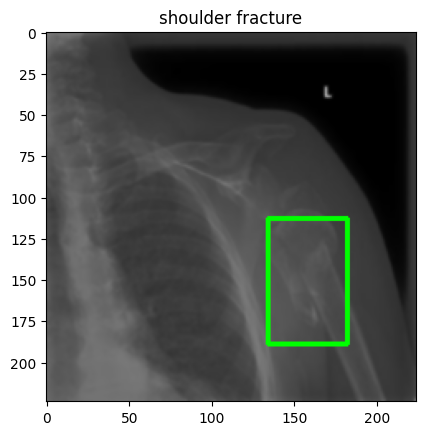

In [12]:
idx = random.randint(0, len(image) - 1)
img, tar = image[idx].permute(1,2,0).numpy(), target[idx]

for bbox in tar['boxes']:
    if isinstance(bbox, list):
        xmin, ymin, xmax, ymax = int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])
        sp, ep = (xmin, ymin), (xmax, ymax)
        cv2.rectangle(img, sp, ep, (0,255,0), 2)
        plt.imshow(img)
        plt.title(classes[tar['labels'][0]])
        plt.show()
    else:
        bbox.numpy()
        xmin, ymin, xmax, ymax = bbox[0].item(), bbox[1].item(), bbox[2].item(), bbox[3].item()
        sp, ep = (xmin, ymin), (xmax, ymax)
        cv2.rectangle(img, sp, ep, (0,255,0), 2)
    
        plt.imshow(img)
        plt.title(classes[tar['labels'][0].tolist()])
        plt.show()

***
### MODEL PROCESSES
***

In [13]:
def train_cycle(model, dataloader, opt):
    model.train()
    train_loss = 0.0
    
    for images, targets in tqdm(dataloader):
        image = [img.to(D) for img in  images]
        target = [{key:(torch.Tensor(value).long().to(D) if isinstance(value, list) else value.to(D)) for key, value in elements.items()} for elements in targets]
        
        opt.zero_grad()
        losses = model(image, target)
        
        loss = sum(loss for loss in losses.values())
        loss.backward()
        opt.step()
        
        train_loss += loss
    for image in images:
        image.to('cpu')
        del image
    for targets in target:
        #target.to('cpu')
        del targets
    gc.collect()
    torch.cuda.empty_cache()
    
    return train_loss / len(dataloader)

In [14]:
def eval_cycle(model, dataloader):
    model.train()
    val_loss = 0.0
    with torch.no_grad():
        torch.cuda.empty_cache()
        for images, targets in tqdm(dataloader):
            image = [img.to(D) for img in  images]
            target = [{key:(torch.Tensor(value).long().to(D) if isinstance(value, list) else value.to(D)) for key, value in elements.items()} for elements in targets]
            
            losses = model(image, target)
            loss = sum(loss for loss in losses.values())
            
            val_loss += loss
        for image in images:
            image.to('cpu')
            del image
        for targets in target:
            #target.to('cpu')
            del targets
        gc.collect()
        torch.cuda.empty_cache()
        return val_loss / len(dataloader)
        

In [15]:
def model_testing(model, testset):
#    model.eval()
#    with torch.no_grad():
#        torch.cuda.empty_cache()
#        for images, targets in tqdm(dataloader):
#            image = [img.to(D) for img in images]
#            target = [{key:(torch.Tensor(value).long().to(D) if isinstance(value, list) else value.to(D)) for key, value in elements.items()} for elements in targets]
#            losses = model(image, target)
#            print(losses)
#            loss = sum(loss for loss in losses.items())
#            test_loss += loss
#           
#        return test_loss / len(dataloader)
    
    idx = random.randint(0,len(test_set)-1)
    print(idx)
    test_img, test_tar = testset[idx]

    model.eval()
    pred=model(test_img.unsqueeze(0).to(D))
    pred1=torchvision.ops.nms(pred[0]['boxes'].detach(),pred[0]['scores'].detach(),0.02)
    xmin,ymin,xmax,ymax=pred[0]['boxes'][0].detach().cpu().long().tolist()
    label=pred[0]['labels'][0].item()

    Txmin,Tymin,Txmax,Tymax=test_tar['boxes'][0].tolist()

    image = cv2.rectangle(test_img.permute(1,2,0).numpy(), (xmin,ymin), (xmax,ymax), (255,0,0), 2)
    image = cv2.rectangle(image, (Txmin,Tymin), (Txmax,Tymax), (0,255,0), 2)
    plt.imshow(image)
    plt.title(classes[label])
    plt.show()

In [16]:
def model_training(model, dataloader1, dataloader2, opt, idx):
    t_traj = []
    v_traj = []
    epoch_list = []
    best_val_loss = np.Inf

    for i in range(epochs):
        train_loss = train_cycle(model, dataloader1, opt)
        val_loss = eval_cycle(model, dataloader2)
    
        t_traj.append(train_loss)
        v_traj.append(val_loss)
        epoch_list.append(i + 1)
        
        print(f"Epochs: {i+1}/{epochs}:- Trainloss: {train_loss}, Valloss: {val_loss}")
        
        if val_loss < best_val_loss:
            torch.save(model.state_dict(), f'/kaggle/working/model{idx + 1}.pt')
            print("Model Updated")
            best_val_loss = val_loss
            
    torch.save(model.state_dict(), f'/kaggle/working/Model{idx + 1}_Trained.pt')
    print("Model Trained")
    print(f"Best. Best Validation Loss: {best_val_loss}")
    
    t_traj = [t.cpu().detach().numpy() for t in t_traj]
    v_traj = [t.cpu().numpy() for t in v_traj]
    plt.plot(epoch_list, t_traj, label='Train')
    plt.plot(epoch_list, v_traj, label='Validation')
    plt.legend()
    plt.title(f"Model{idx + 1}Training/Validation Loss Comparison by Epoch")
    plt.show()
    torch.cuda.empty_cache()

***
### MODELS - ResNet50, Mobilenet backbones
***

In [17]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN_ResNet50_FPN_Weights, FasterRCNN_ResNet50_FPN_V2_Weights, FasterRCNN_MobileNet_V3_Large_FPN_Weights, FasterRCNN_MobileNet_V3_Large_320_FPN_Weights

model1 = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT, 
    preTrained=True)
input_features1 = model1.roi_heads.box_predictor.cls_score.in_features
model1.roi_heads.box_predictor = FastRCNNPredictor(input_features1, num_classes)
optimizer1=torch.optim.Adam(model1.parameters(),lr=LR)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 62.0MB/s] 


In [18]:
model2 = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(
    weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT,
    preTrained=True)
input_features2 = model2.roi_heads.box_predictor.cls_score.in_features
model2.roi_heads.box_predictor = FastRCNNPredictor(input_features2, num_classes)
optimizer2=torch.optim.Adam(model2.parameters(),lr=LR)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth
100%|██████████| 167M/167M [00:02<00:00, 69.7MB/s] 


In [19]:
model3 = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(
    weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT,
    preTrained=True)
input_features3 = model3.roi_heads.box_predictor.cls_score.in_features
model3.roi_heads.box_predictor = FastRCNNPredictor(input_features3, num_classes)
optimizer3=torch.optim.Adam(model3.parameters(),lr=LR)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:05<00:00, 15.1MB/s]


In [20]:
model4 = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(
    weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT,
    preTrained=True)
input_features4 = model4.roi_heads.box_predictor.cls_score.in_features
model4.roi_heads.box_predictor = FastRCNNPredictor(input_features4, num_classes)
optimizer4=torch.optim.Adam(model4.parameters(),lr=LR)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth
100%|██████████| 74.2M/74.2M [00:05<00:00, 15.2MB/s]


In [21]:
models = [model1, model2, model3, model4]
optimizers = [optimizer1, optimizer2, optimizer3, optimizer4]

100%|██████████| 29/29 [00:11<00:00,  2.49it/s]


Epochs: 1/5:- Trainloss: 0.18589289486408234, Valloss: 0.18786396086215973
Model Updated


100%|██████████| 29/29 [00:08<00:00,  3.52it/s]


Epochs: 2/5:- Trainloss: 0.20621474087238312, Valloss: 0.2186586558818817


100%|██████████| 29/29 [00:08<00:00,  3.56it/s]


Epochs: 3/5:- Trainloss: 0.22894275188446045, Valloss: 0.2350991815328598


100%|██████████| 29/29 [00:08<00:00,  3.60it/s]


Epochs: 4/5:- Trainloss: 0.24366891384124756, Valloss: 0.3389054536819458


100%|██████████| 29/29 [00:08<00:00,  3.54it/s]


Epochs: 5/5:- Trainloss: 0.25863727927207947, Valloss: 0.3786875307559967
Model Trained
Best. Best Validation Loss: 0.18786396086215973


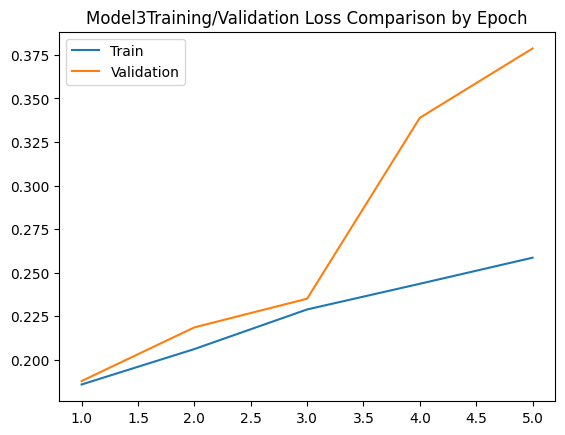

3


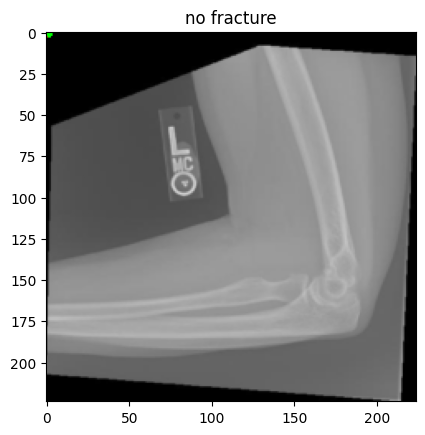

In [22]:
torch.nn.DataParallel(models[2])
models[2].to(D)
model_training(models[2], train_loader, val_loader, optimizers[2], 2)
model_testing(models[2], test_set)
models[2].to('cpu')
models[2] = None
gc.collect()
torch.cuda.empty_cache()
    